In [149]:
import pandas as pd
import os
import re
import networkx as nx
import networkx.algorithms.community as nx_comm
from networkx.algorithms.community.label_propagation import label_propagation_communities
# from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import difflib


import geopandas as gpd

from libs.mrqap import MRQAP # source: https://github.com/lisette-espin/mrqap-python
import geopy.distance
import itertools


In [4]:
_DATA_DIRECTORY = 'C:\\Users\\josia\\Documents\\GitHub\\modernDataAnalytics2022\\data\\'
path = "C:\\Users\\josia\\Documents\\GitHub\\modernDataAnalytics2022"

def full_path(path):
    return os.path.join(_DATA_DIRECTORY, path)

In [5]:
# relative paths weren't working for me for some damn reason
from os import listdir
from os.path import isfile, join
os.listdir("data")
os.getcwd()
# onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

'C:\\Users\\josia\\Documents\\GitHub\\modernDataAnalytics2022'

In [6]:
# Data imports here my duder
path = "C:\\Users\\josia\\Documents\\GitHub\\modernDataAnalytics2022"
data_1 = pd.read_excel("C:\\Users\\josia\\Documents\\GitHub\\modernDataAnalytics2022\\data\\ESC-2014-first_semi-final-full_results.xls")

In [7]:
def Eurovision_Decade_DataFrame(csv_path, vote_type = "Both", round_type = "all", y1="NA", y2="NA"):
    # probably enforce types or something here
    
    
    longform_data = pd.read_csv(csv_path)
    longform_data = longform_data[longform_data["From country"] != longform_data_decades["To country"]]
    contest_round = list(longform_data['(semi-) final'].unique())
    for version in contest_round:
        locals()["census_"+str(version)] = longform_data[longform_data['(semi-) final']==version].groupby('Year').nunique()[['From country','To country']]
        locals()["census_"+str(version)]['(semi-) final'] = str(version)
        locals()["census_"+str(version)].reset_index()
        locals()["census_"+str(version)].rename(columns = {'From country':'sum_senders_'+str(version), 'To country':'sum_receivers_'+str(version)}, inplace = True)
        if contest_round.index(version) == 0: 
            merged_rounds = pd.merge(longform_data, locals()["census_"+str(version)], how='left', on=['Year', '(semi-) final'])
        else:
            merged_rounds = pd.merge(merged_rounds, locals()["census_"+str(version)], how='left', on=['Year', '(semi-) final'])
    merged_rounds = merged_rounds.fillna(0)

    merged_rounds["sum_senders"] = merged_rounds["sum_senders_sf"] + merged_rounds["sum_senders_sf1"] + merged_rounds["sum_senders_f"] + merged_rounds["sum_senders_sf2"] 
    merged_rounds["sum_receivers"] = merged_rounds["sum_receivers_sf"] + merged_rounds["sum_receivers_sf2"] + merged_rounds["sum_receivers_f"]  + merged_rounds["sum_receivers_sf1"] 
    merged_rounds = merged_rounds.drop(['sum_senders_sf', 'sum_senders_sf1', "sum_senders_f", 'sum_senders_sf2', 'sum_receivers_sf', "sum_receivers_sf2", "sum_receivers_f", "sum_receivers_sf1"], axis=1)
    merged_rounds['Decade'] = (10 * (merged_rounds['Year'] // 10)).astype(str) + 's'
    merged_rounds["average_points"] = merged_rounds["Points"]/merged_rounds["sum_senders"]
    
    if round_type != "all" and round_type == "finals":
        merged_rounds = merged_rounds[merged_rounds['(semi-) final'] == "f"]
    elif round_type != "all" and round_type == "semis":
        merged_rounds = merged_rounds[(merged_rounds['(semi-) final'] == "sf") | (merged_rounds['(semi-) final'] == "sf1") | (merged_rounds['(semi-) final'] == "sf2")]
    else:
        pass
    merged_rounds["contests_incl"] = str(round_type)
    
    if y1 != "NA" and y2 != "NA":
        merged_rounds = merged_rounds[(merged_rounds['Year'] >= y1) & (merged_rounds['Year'] <= y2)]
    else:
        pass
    
    if vote_type == "J" or vote_type == "T":
        merged_rounds = merged_rounds[merged_rounds["Jury or Televoting"] == vote_type]
        decade_grouping = merged_rounds.groupby(["Decade","From country", "To country"]).sum()
        decade_grouping = decade_grouping.reset_index()
    else:
        decade_grouping = merged_rounds.groupby(["Decade","From country", "To country"]).sum()
        decade_grouping = decade_grouping.reset_index()
    decade_grouping["Contests_Shared"] = (decade_grouping["Year"]/2000).round(0).astype(int)
    return decade_grouping


In [ ]:

def similar(landstring, country):
    shitter = process.extractOne(landstring, country, score_cutoff=90)
    if shitter == None:
        return "NA"
    else:
        return shitter[0]
    

In [ ]:
def fuzzy_merge(df_1, df_2, key1, key2, threshold=90, limit=1):
    s = df_2[key2].tolist()
    m = df_1[key1].apply(lambda x: process.extract(x, s, limit=limit))    
    df_1['matches'] = m
    m2 = df_1['matches'].apply(lambda x: ', '.join([i[0] for i in x if i[1] >= threshold]))
    df_1['matches'] = m2
    
    return df_1

In [8]:
def Decade_subset(df_decades, decade="all"):
    if decade == "all":
        return df_decades     
    else:
        locals()["eurovision_"+str(decade)] = df_decades[df_decades["Decade"] == str(decade)+"s"].sort_values(by=['average_points'],  ascending=False)
        return locals()["eurovision_"+str(decade)]

In [9]:
# maybe it would be best to split this function up somehow...
%matplotlib inline
def network_and_communities(dataframe, show_plot = "N"):
    dataframe_network = nx.from_pandas_edgelist(dataframe, "From country", "To country", ["average_points"])
    communities = label_propagation_communities(dataframe_network)
    print([community for community in communities])

    
    nx.draw(dataframe_network)
    if show_plot == "Y":
        plt.show()
    else:
        pass
    return dataframe_network


In [10]:
# some function to subset the duders by their favorites

# the nlargest memer isn't working properly, needs to be the top of each country methinks...

# need to redo the flow of this, if years is something then it doesn't return what I want 
def cutoff_values(dataframe, min_years_with = "all", top="NA", points="NA"):
    if min_years_with != "all" and top != "NA":
        dataframe = dataframe[dataframe["Contests_Shared"] >= min_years_with]
    else:
        if top != "NA":
            favorites = dataframe.nlargest(top, 'average_points')
        else:
            pass
        if points != "NA":
            favorites = dataframe[dataframe["average_points"] >= points]
        else:
            pass
    return favorites

In [11]:
# some function to give some basic characteristics of whatever network is passed to it..
def network_characteristics(dataframe, weight = "average_points"):
    network_of_interest = nx.from_pandas_edgelist(dataframe, "From country", "To country", [weight],
                                   create_using=nx.DiGraph())
    census = nx.triadic_census(network_of_interest)
    centrality = nx.degree_centrality(network_of_interest)
    centrality = pd.DataFrame.from_dict(centrality, orient='index', columns=['centrality']).sort_values(by=["centrality"], ascending=False)
    return census, centrality
    

In [174]:
longform_data_decades = pd.read_csv("C:\\Users\\josia\\Documents\\GitHub\\modernDataAnalytics2022\\data\\Voting_totals.csv")
shitteringo = list(longform_data_decades['(semi-) final'].unique())
shitteringo.index('f')


testererer = Eurovision_Decade_DataFrame("C:\\Users\\josia\\Documents\\GitHub\\modernDataAnalytics2022\\data\\Voting_totals.csv", 
                                         round_type = "semis")

testererer
# testererer[testererer["From country"] == "Australia"].sort_values(by=['average_points'],  ascending=False)
# cutoff_values(testererer,  min_years_with = 5, points = 3)

# testererer.sort_values(by=['Contests_Shared'],  ascending=True).head(20)
# testererer[(testererer["Contests_Shared"] == 1) & (testererer["Decade"] == "2010s")]


# testererer[(testererer["From country"] == "Albania") & (testererer["To country"] == "Macedonia")]
# s4[(s4['Year'] >= 2000) & (s4['Year'] <= 2005)]
# print(network_characteristics(cutoff_values(testererer, points = 3)))
# network_characteristics(cutoff_values(testererer, points = 3), weight = "Points")


# network_and_communities(Decade_subset(testererer, decade = "1980"))
# Decade_subset(testererer, decade = "1980")

,Decade,From country,To country,Year,Points,Duplicate,sum_senders,sum_receivers,average_points,Contests_Shared
0,2000s,Albania,Andorra,8022,6,0,155.0,98.0,0.153846,4
1,2000s,Albania,Armenia,2006,3,0,38.0,23.0,0.078947,1
2,2000s,Albania,Austria,4012,5,0,81.0,53.0,0.128205,2
3,2000s,Albania,Azerbaijan,2009,0,0,22.0,19.0,0.000000,1
4,2000s,Albania,Belarus,10030,4,0,177.0,117.0,0.095238,5
...,...,...,...,...,...,...,...,...,...,...
3618,2010s,United Kingdom,Sweden,10071,21,0,103.0,88.0,1.015038,5
3619,2010s,United Kingdom,Switzerland,16118,9,0,165.0,142.0,0.443723,8
3620,2010s,United Kingdom,The Netherlands,6035,12,0,59.0,51.0,0.611529,3
3621,2010s,United Kingdom,Turkey,6033,15,0,61.0,54.0,0.754386,3


In [139]:

def proc_english(dataframe):
    english = pd.read_csv(full_path(dataframe),  header=0,  skiprows=1)
    english = english.rename(columns = {'%':'percent_english'})
    english["percent_english"] = english["percent_english"].str.replace("2012", "")
    english["percent_english"] =  [re.sub(r"\((.*?)\)", "", str(x)) for x in english["percent_english"]]

    participants = Eurovision_Decade_DataFrame("C:\\Users\\josia\\Documents\\GitHub\\modernDataAnalytics2022\\data\\Voting_totals.csv", 
                                         round_type = "all")["From country"].unique()
    match_dict = dict((land, similar(land.upper(), gdp_per_capita["Entity"])) for land in participants)
    match_dict = pd.DataFrame.from_dict(match_dict, orient='index')
    match_dict.reset_index()
    match_dict['Country'] = match_dict.index

    eng_data = fuzzy_merge(english, match_dict, 'Country', 'Country', threshold=90, limit=1)
    eng_data['matches'].replace('', np.nan, inplace=True)
    eng_data.dropna(subset=['matches'], inplace=True)
    eng_data = eng_data.drop(['Country'], axis=1)
    eng_data["percent_english"] = eng_data["percent_english"].astype(float)
    eng_data = eng_data.drop(['No.', 'Eligible population', 'No..1', '%.1', 'No..2', '%.2', 'Notes'], axis=1)
    return eng_data



In [133]:
# gonna take a global variable... the output of Eurovision

def proc_gdppc(dataframe, year = "all"):
    gdp_per_capita = pd.read_csv(full_path(dataframe),  header=0)
    if year != "all":
        gdp_per_capita = gdp_per_capita[gdp_per_capita["Year"] == int(year)]
    else:
        pass
    participants = Eurovision_Decade_DataFrame("C:\\Users\\josia\\Documents\\GitHub\\modernDataAnalytics2022\\data\\Voting_totals.csv", 
                                         round_type = "all")["From country"].unique()
    match_dict = dict((land, similar(land.upper(), gdp_per_capita["Entity"])) for land in participants)
    match_dict = pd.DataFrame.from_dict(match_dict, orient='index')
    match_dict.reset_index()
    match_dict['Country'] = match_dict.index

    merged_data = fuzzy_merge(gdp_per_capita, match_dict, 'Entity', 'Country', threshold=90, limit=1)
    merged_data['matches'].replace('', np.nan, inplace=True)
    merged_data.dropna(subset=['matches'], inplace=True)
    merged_data = merged_data.drop(['Code', 'Entity'], axis=1)
    merged_data.rename(columns={r"GDP per capita, PPP (constant 2017 international $)": "GDP_PPP_2017_dol"}, errors="raise", inplace=True)
    merged_data["GDP_PPP_2017_dol"] = merged_data["GDP_PPP_2017_dol"].round(2)
    return merged_data

[{'Belgium', 'Portugal', 'Denmark', 'Germany'}, {'Ireland', 'Austria', 'Sweden', 'United Kingdom', 'Norway', 'Switzerland', 'Luxembourg'}, {'Turkey', 'Spain', 'Italy', 'Yugoslavia'}]


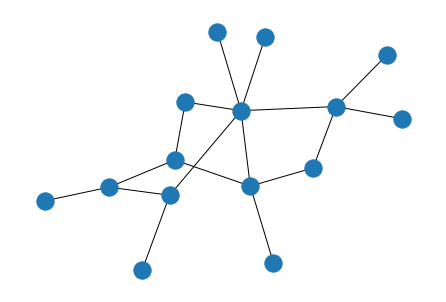

In [15]:
testererer = Decade_subset(Eurovision_Decade_DataFrame("C:\\Users\\josia\\Documents\\GitHub\\modernDataAnalytics2022\\data\\Voting_totals.csv", 
                                         round_type = "all"), decade = "1980")

network_and_communities(cutoff_values(testererer,  min_years_with = 5, points = 3), show_plot = "Y")

[{'Cyprus', 'Greece'}, {'France', 'Norway'}, {'Sweden', 'Iceland'}, {'Ireland', 'United Kingdom', 'Belgium'}]


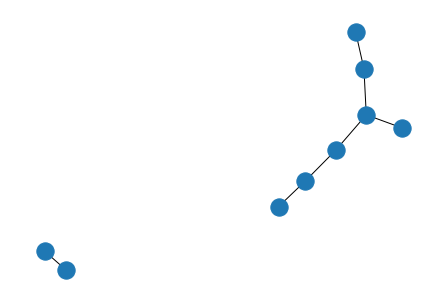

In [16]:
testererer = Decade_subset(Eurovision_Decade_DataFrame("C:\\Users\\josia\\Documents\\GitHub\\modernDataAnalytics2022\\data\\Voting_totals.csv", 
                                         round_type = "all"), decade = "1990")

network_and_communities(cutoff_values(testererer, top = 8), show_plot = "Y")

[{'Turkey', 'France', 'The Netherlands', 'Germany'}, {'Croatia', 'Bosnia & Herzegovina', 'Slovenia'}, {'Estonia', 'Latvia', 'Russia'}, {'Sweden', 'Iceland', 'Denmark'}, {'Cyprus', 'Greece'}, {'Ireland', 'United Kingdom'}]


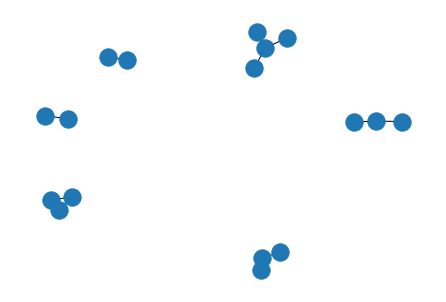

In [19]:
testererer = Decade_subset(Eurovision_Decade_DataFrame("C:\\Users\\josia\\Documents\\GitHub\\modernDataAnalytics2022\\data\\Voting_totals.csv", 
                                         round_type = "all", y1 = 2000, y2 = 2006), decade = "2000")

network_and_communities(cutoff_values(testererer, top = 15), show_plot = "Y")

[{'Turkey', 'France', 'Belgium', 'United Kingdom', 'Albania', 'Germany', 'F.Y.R. Macedonia'}, {'Israel', 'Armenia', 'Russia'}, {'Portugal', 'Switzerland'}, {'Slovenia', 'Bosnia & Herzegovina'}, {'Sweden', 'Finland', 'Iceland'}]


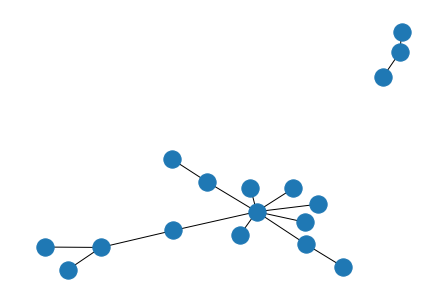

In [20]:
testererer = Decade_subset(Eurovision_Decade_DataFrame("C:\\Users\\josia\\Documents\\GitHub\\modernDataAnalytics2022\\data\\Voting_totals.csv", 
                                         round_type = "all", y1 = 2006, y2 = 2010), decade = "2000")

network_and_communities(cutoff_values(testererer, top = 15), show_plot = "Y")

[{'Turkey', 'France', 'Belgium', 'The Netherlands', 'Germany'}, {'Latvia', 'Estonia', 'Lithuania', 'Russia'}, {'Cyprus', 'Greece'}, {'Sweden', 'Iceland', 'Denmark'}, {'Croatia', 'Bosnia & Herzegovina', 'Slovenia'}]


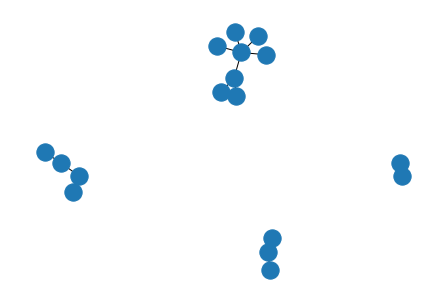

In [21]:
testererer = Decade_subset(Eurovision_Decade_DataFrame("C:\\Users\\josia\\Documents\\GitHub\\modernDataAnalytics2022\\data\\Voting_totals.csv", 
                                         round_type = "all"), decade = "2000")

network_and_communities(cutoff_values(testererer, top = 15), show_plot = "Y")

[{'Cyprus', 'Greece', 'Albania'}, {'Moldova', 'Russia', 'Romania'}, {'Sweden', 'Norway', 'Denmark'}, {'Ireland', 'United Kingdom', 'Lithuania'}, {'Georgia', 'Azerbaijan'}, {'Belarus', 'Ukraine'}, {'Serbia', 'F.Y.R. Macedonia'}]


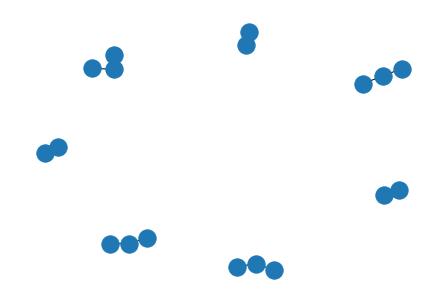

In [22]:
testererer = Decade_subset(Eurovision_Decade_DataFrame("C:\\Users\\josia\\Documents\\GitHub\\modernDataAnalytics2022\\data\\Voting_totals.csv", 
                                         round_type = "all"), decade = "2010")

network_and_communities(cutoff_values(testererer, top = 15), show_plot = "Y")

[{'Cyprus', 'Greece', 'Armenia'}, {'Ireland', 'United Kingdom', 'Lithuania'}, {'Serbia', 'Switzerland', 'Slovenia', 'Hungary'}, {'F.Y.R. Macedonia', 'Israel', 'Bulgaria'}, {'Czech Republic', 'Azerbaijan'}, {'Norway', 'Denmark'}, {'Poland', 'Italy', 'Ukraine'}]


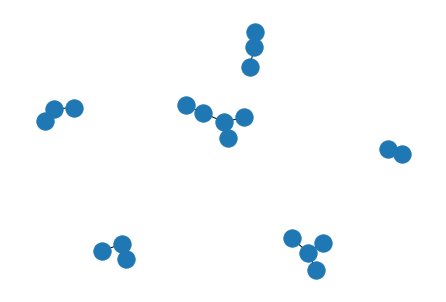

In [23]:
testererer = Eurovision_Decade_DataFrame("C:\\Users\\josia\\Documents\\GitHub\\modernDataAnalytics2022\\data\\Voting_totals.csv", 
                                         round_type = "all", vote_type = "T")

network_and_communities(cutoff_values(testererer, top = 15), show_plot = "Y")

[{'Moldova', 'Russia', 'Romania'}, {'Cyprus', 'Greece', 'Albania'}, {'Turkey', 'France', 'Germany'}, {'The Netherlands', 'Sweden', 'Norway', 'Denmark'}, {'Armenia', 'Georgia', 'Azerbaijan'}]


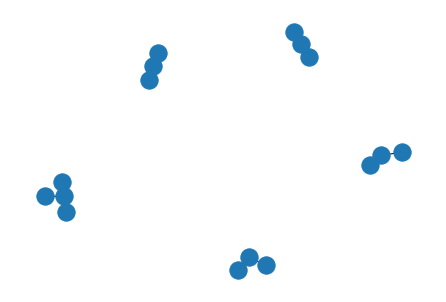

In [24]:
testererer = Eurovision_Decade_DataFrame("C:\\Users\\josia\\Documents\\GitHub\\modernDataAnalytics2022\\data\\Voting_totals.csv", 
                                         round_type = "all", vote_type = "J")

network_and_communities(cutoff_values(testererer, top = 15), show_plot = "Y")

[{'Cyprus', 'Greece', 'Albania'}, {'Moldova', 'Russia', 'Romania'}, {'Sweden', 'Norway', 'Denmark'}, {'Ireland', 'United Kingdom', 'Lithuania'}, {'Georgia', 'Azerbaijan'}, {'Belarus', 'Ukraine'}, {'Serbia', 'F.Y.R. Macedonia'}]


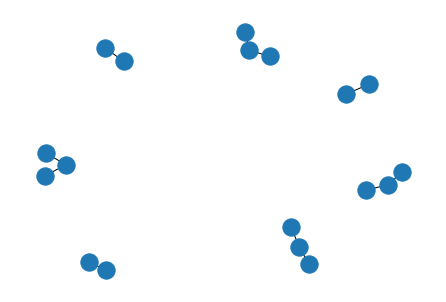

In [25]:
testererer = Eurovision_Decade_DataFrame("C:\\Users\\josia\\Documents\\GitHub\\modernDataAnalytics2022\\data\\Voting_totals.csv", 
                                         round_type = "all")

network_and_communities(cutoff_values(testererer, top = 15), show_plot = "Y")

In [26]:
 Eurovision_Decade_DataFrame("C:\\Users\\josia\\Documents\\GitHub\\modernDataAnalytics2022\\data\\Voting_totals.csv", 
                                         round_type = "all")["average_points"].mean()


0.7405220298765032

In [27]:
# what about never voting for others??
# fucker_dislikes = fucker[fucker["average_points"] == 0]
# fucker_dislikes["Year"].unique()

In [28]:
# fucker_dislikes = fucker_dislikes[fucker_dislikes["Year"] >= 16000]
# fucker_dislikes["Year"] = round(fucker_dislikes["Year"]/2000, 2)

In [29]:
# fucker_dislikes["Year"].hist()

In [30]:

# dislikes = nx.from_pandas_edgelist(fucker_dislikes, "From country", "To country", ["Year"],
#                                    create_using=nx.DiGraph())

# weights = [round(dislikes[u][v]['Year'])/4 for u, v in dislikes.edges() if u != v]

# for n1,n2,attr in dislikes.edges(data=True):
#     print(n1,n2,attr)
# print(weights)
    
    
# fig = plt.figure(1, figsize=(17, 8), dpi=80)


# pos = nx.spring_layout(dislikes, k =.8)

# nx.draw_networkx_nodes(dislikes, pos, node_color='lightblue', node_size=200, label=True)
# nx.draw_networkx_edges(dislikes, pos, arrows=True, alpha = 0.5, width = weights)
# nx.draw_networkx_labels(dislikes, pos, font_color='r', font_size=10)


# # nx.draw_networkx(dislikes, with_labels = True, width = weights,pos = nx.spring_layout(, ), )

In [31]:
# from networkx.algorithms.community.label_propagation import label_propagation_communities
# undirected_dislikes = nx.from_pandas_edgelist(fucker_dislikes, "From country", "To country", ["Year"])
# # Didn't actually detect community because all are connected...
# communities = label_propagation_communities(undirected_dislikes)
# print([community for community in communities])

In [65]:
# # load geographic coordinate system for countries
import csv
country = [row[0].strip() for row in csv.reader(open(full_path("LonLat.csv")), delimiter=';')]    # clear spaces
# lat = [float(row[1]) for row in csv.reader(open(path + '\\LonLat.csv'), delimiter=';')]
# lon = [float(row[2]) for row in csv.reader(open(path + '\\LonLat.csv'), delimiter=';')]
# # define position in basemap
# position = {}
# for i in range(0, len(country)):
#     position[country[i]] = m(lon[i], lat[i])
country

['AFGHANISTAN',
 'ALBANIA',
 'ALGERIA',
 'AMERICAN SAMOA',
 'ANDORRA',
 'ANGOLA',
 'ANGUILLA',
 'ANTARCTICA',
 'ANTIGUA AND BARBUDA',
 'ARGENTINA',
 'ARMENIA',
 'ARUBA',
 'AUSTRALIA',
 'AUSTRIA',
 'AZERBAIJAN',
 'BAHAMAS',
 'BAHRAIN',
 'BANGLADESH',
 'BARBADOS',
 'BELARUS',
 'BELGIUM',
 'BELIZE',
 'BENIN',
 'BERMUDA',
 'BHUTAN',
 'BOLIVIA',
 'BOSNIA AND HERZEGOVINA',
 'BOTSWANA',
 'BOUVET ISLAND',
 'BRAZIL',
 'BRITISH INDIAN OCEAN TERRITORY',
 'BRUNEI',
 'BULGARIA',
 'BURKINA FASO',
 'BURUNDI',
 'CAMBODIA',
 'CAMEROON',
 'CANADA',
 'CAPE VERDE',
 'CAYMAN ISLANDS',
 'CENTRAL AFRICAN REPUBLIC',
 'CHAD',
 'CHILE',
 'CHINA',
 'CHRISTMAS ISLAND',
 'COCOS (KEELING) ISLANDS',
 'COLOMBIA',
 'COMOROS',
 'CONGO',
 'COOK ISLANDS',
 'COSTA RICA',
 'COTE IVOIRE',
 'CROATIA (HRVATSKA)',
 'CUBA',
 'CYPRUS',
 'CZECH REPUBLIC',
 'DENMARK',
 'DJIBOUTI',
 'DOMINICA',
 'DOMINICAN REPUBLIC',
 'ECUADOR',
 'EGYPT',
 'EL SALVADOR',
 'EQUATORIAL GUINEA',
 'ERITREA',
 'ESTONIA',
 'ETHIOPIA',
 'FALKLAND ISLANDS'

In [67]:
shitter_coords = pd.read_csv(full_path("LonLat.csv"), delimiter=";", 
                  names=["Country", "Lat", "Lon"])
shitter_coords

,Country,Lat,Lon
0,AFGHANISTAN,33.0000,65.0
1,ALBANIA,41.0000,20.0
2,ALGERIA,28.0000,3.0
3,AMERICAN SAMOA,-14.3333,-170.0
4,ANDORRA,42.5000,1.5
...,...,...,...
230,WESTERN SAHARA,24.5000,-13.0
231,YEMEN,15.0000,48.0
232,ZAIRE,-20.0000,30.0
233,ZAMBIA,-15.0000,30.0


In [84]:
# Finding distance between countries!
def proc_distance(dataframe):
    country = [row[0].strip() for row in csv.reader(open(full_path(dataframe)), delimiter=';')]
    pos = dict((land, similar(land.upper(), country)) for land in testererer["From country"].unique())
    take_2_2 = pd.DataFrame.from_dict(pos, orient='index')
    take_2_2.reset_index()
    take_2_2['Country'] = take_2_2.index
    fuzzy_merged = fuzzy_merge(shitter_coords, take_2_2, "Country", "Country", threshold=90, limit=1)
    fuzzy_merged['matches'].replace('', np.nan, inplace=True)
    fuzzy_merged.dropna(subset=['matches'], inplace=True)
    fuzzy_merged = fuzzy_merged.drop(['Country'], axis=1)
    print(len(fuzzy_merged["matches"]))
    dictionary_pos = fuzzy_merged.set_index('matches').T.to_dict('list')

    # for val in dictionary_pos:
    list_new = []
    for a, b in itertools.combinations(dictionary_pos, 2):
        list_new.append({"Country_A": a, "Country_B": b, "Distance": round(geopy.distance.geodesic(dictionary_pos[a], dictionary_pos[b]).km, 2)})

    distance_matrix = pd.DataFrame.from_dict(list_new)
    return distance_matrix



In [122]:
len(proc_english('EnglischLanguage.csv')["matches"].unique())

36

In [81]:

len(proc_gdppc(dataframe = 'gdp-per-capita-worldbank.csv', year = 2000)["matches"])




48

In [85]:
len(proc_distance("LonLat.csv")["Distance"])


51


C:\Users\josia\Anaconda3\envs\test_python\lib\site-packages\ipykernel_launcher.py:13: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  del sys.path[0]


1176

In [140]:
# TODO: FIND A WAY TO GET THE COMMON ENTRIES OF THESE DATAFRAMES SO A MATRIX CAN BE CONSTRUCTED..
english = proc_english('EnglischLanguage.csv')
gdp_data = proc_gdppc(dataframe = 'gdp-per-capita-worldbank.csv', year = 2000)
distance_data = proc_distance("LonLat.csv")



51


C:\Users\josia\Anaconda3\envs\test_python\lib\site-packages\ipykernel_launcher.py:13: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  del sys.path[0]


In [199]:
eng_gdp = list(set(distance_data["Country_A"]).intersection(gdp_data["matches"].unique()))
acceptable_countries = list(set(eng_gdp).intersection(english["matches"].unique()))
acceptable_countries = list(set(acceptable_countries).intersection(point_shares["From_country"].unique()))

acceptable_countries

['Cyprus',
 'Australia',
 'Latvia',
 'Norway',
 'Switzerland',
 'Ireland',
 'Spain',
 'Lithuania',
 'Bulgaria',
 'Austria',
 'Hungary',
 'Estonia',
 'Greece',
 'Sweden',
 'France',
 'Italy',
 'The Netherlands',
 'Germany',
 'Denmark',
 'Malta',
 'Turkey',
 'Portugal',
 'Belgium',
 'Israel',
 'Russia',
 'Croatia',
 'Slovenia',
 'Romania',
 'Poland',
 'Finland']

In [76]:
# cluster = pd.DataFrame.from_dict(communities)
# cluster['cluster'] = range(1, len(cluster) + 1)
# print(cluster.head(10))
# print(communities)

# # I guess louvain probably works the best for getting these labels without struggle
# from community import community_louvain
# partition = community_louvain.best_partition(fuckerpre_2006_favorites_network)
# partition


# for com in set(partition.values()) :
#     count = count + 1.
#     list_nodes = [nodes for nodes in partition.keys()
#                                 if partition[nodes] == com]

In [130]:
# clusters_df = pd.DataFrame.from_dict(partition, orient='index', columns=['cluster']).reset_index()
# clusters_df.rename(columns={"index": "Country"}, errors="raise", inplace=True)
# clusters_df
# # partition


In [ ]:
# this was stolen from:
# https://github.com/DataMettle/eurovision/blob/master/Modelling%20Eurovision%20voting%20patterns.ipynb


# Download the file: Done!
# https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_0_countries.zip
# and place the contents of the zip in the data folder.

country_codes = pd.read_csv(full_path('country_codes.csv'))

shapefile = full_path('ne_10m_admin_0_countries.shp')
shape = gpd.read_file(shapefile)
gdf = shape.to_crs("+init=epsg:3035")
gdf_australia = shape.to_crs("+init=epsg:3577")

# Each country needs to be outputted with a label..
# take this from our network outputs
# clusters_df = pd.DataFrame(
#     {
#         'Country': countries,
#         'cluster': clusters,
#     }
# )


def merge_with_map(map_df, country_codes):
    """Adds full country names to country codes. Also adjusts some country names."""
    return (
        pd.merge(map_df, country_codes)
        .replace({'Russian Federation': 'Russia',
                  'Netherlands': 'The Netherlands',
                  'Czechia': 'Czech Republic',
                  'Bosnia and Herzegovina': 'Bosnia & Herzegovina',
                  'Moldova, Republic of': 'Moldova',
                  'Macedonia, the former Yugoslav Republic of': 'F.Y.R. Macedonia'})
    )

eurovision_map = merge_with_map(gdf, country_codes)

eurovision_map_australia = merge_with_map(gdf_australia, country_codes)

In [ ]:
# This shit is straight up stolen from kaggle so probably change parts of it!

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

f, ax = plt.subplots(1, figsize=(11, 10))
f.subplots_adjust(hspace=0.0, wspace=0.0)
gdf.plot(ax=ax, color='lightgrey')

eurovision_map_cluster = pd.merge(eurovision_map, clusters_df, left_on='Country name', right_on='Country')


# Gonna have to change the cmap s.t. any number of colors are taken.. maybe some viridis color pallete or something
eurovision_map_cluster[eurovision_map_cluster['cluster'] == 0].plot(ax=ax,
                                                                    color='r',
                                                                    vmin=-0.05)
eurovision_map_cluster[eurovision_map_cluster['cluster'] == 1].plot(ax=ax,
                                                                    vmin=-0.05)

eurovision_map_australia_cluster = pd.merge(eurovision_map_australia, clusters_df, left_on='Country name', right_on='Country')
inset_ax = inset_axes(ax, 
                      width=1.5*(2.5/1.5),
                      height=1.2*(2.5/1.5),
                      loc=1)
gdf_australia.plot(ax=inset_ax, color='lightgrey')
eurovision_map_australia_cluster.plot(ax=inset_ax,
                                      cmap='Purples',
                                      vmin=-0.05)
inset_ax.set_xlim(-0.21e7, 0.22e7)
inset_ax.set_ylim(-0.49e7, -0.1e7)
inset_ax.axes.get_xaxis().set_visible(False)
inset_ax.axes.get_yaxis().set_visible(False)

eurovision_map_cluster[eurovision_map_cluster['cluster'] == 2].plot(ax=ax,
                                                                    color='g',
                                                                    vmin=-0.05)
eurovision_map_cluster[eurovision_map_cluster['cluster'] == 3].plot(ax=ax,
                                                                    color='y',
                                                                    vmin=-0.05)
eurovision_map_cluster[eurovision_map_cluster['cluster'] == 4].plot(ax=ax,
                                                                    color='m',
                                                                    vmin=-0.05)
eurovision_map_cluster[eurovision_map_cluster['cluster'] == 5].plot(ax=ax,
                                                                    color='purple',
                                                                    vmin=-0.05)

ax.set_xlim(0.25e7, 0.77e7)
ax.set_ylim(0.10e7, 0.56e7)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
# plt.savefig('images/clusters_map.png', bbox_inches='tight', dpi=150)

In [200]:
distance_data = distance_data[(distance_data['Country_A'].isin(acceptable_countries)) & (distance_data['Country_B'].isin(acceptable_countries))]
distance_data


gdp_data = gdp_data[(gdp_data['matches'].isin(acceptable_countries))]
english = english[(english['matches'].isin(acceptable_countries))]

gdp_data.head()

,Year,GDP_PPP_2017_dol,matches
336,2000,38343.00,Australia
367,2000,46403.28,Austria
584,2000,43023.31,Belgium
889,2000,10201.28,Bulgaria
1446,2000,18183.59,Croatia


In [215]:
# How to get adjacency matrix...
df = pd.crosstab(gdp_data.matches, gdp_data.matches, gdp_data.GDP_PPP_2017_dol, aggfunc=sum)
idx = df.columns.union(df.index)
df = df.reindex(index = idx, columns=idx, fill_value=0)
df = df.fillna(0)
# df_gdp = df + df.T - np.diag(np.diag(df))
df_gdp

matches,Australia,Austria,Belgium,Bulgaria,Croatia,Cyprus,Denmark,Estonia,Finland,France,...,Poland,Portugal,Romania,Russia,Slovenia,Spain,Sweden,Switzerland,The Netherlands,Turkey
matches,,,,,,,,,,,,,,,,,,,,,
Australia,38343.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00
Austria,0.0,46403.28,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00
Belgium,0.0,0.00,43023.31,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00
Bulgaria,0.0,0.00,0.00,10201.28,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00
Croatia,0.0,0.00,0.00,0.00,18183.59,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00
Cyprus,0.0,0.00,0.00,0.00,0.00,33013.98,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00
Denmark,0.0,0.00,0.00,0.00,0.00,0.00,48907.01,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00
Estonia,0.0,0.00,0.00,0.00,0.00,0.00,0.00,17778.97,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00
Finland,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,39894.19,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00


In [216]:
# How to get adjacency matrix...
df = pd.crosstab(english.matches, english.matches, english.percent_english, aggfunc=sum)
idx = df.columns.union(df.index)
df = df.reindex(index = idx, columns=idx, fill_value=0)
df = df.fillna(0)
# df_eng = df + df.T - np.diag(np.diag(df))
df_eng

matches,Australia,Austria,Belgium,Bulgaria,Croatia,Cyprus,Denmark,Estonia,Finland,France,...,Poland,Portugal,Romania,Russia,Slovenia,Spain,Sweden,Switzerland,The Netherlands,Turkey
matches,,,,,,,,,,,,,,,,,,,,,
Australia,92.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0
Austria,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0
Belgium,0.0,0.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0
Bulgaria,0.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0
Croatia,0.0,0.0,0.0,0.0,60.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0
Cyprus,0.0,0.0,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0
Denmark,0.0,0.0,0.0,0.0,0.0,0.0,86.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0
Estonia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0
Finland,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0


In [218]:
#######################################################################
# Constants
#######################################################################
NCOUNTRIES = 30
DIRECTED = True
NPERMUTATIONS = 2000

In [93]:
def getMatrix(path, directed=False, log1p=False):
    matrix = np.zeros(shape=(NCOUNTRIES,NCOUNTRIES))
    with open(path, 'r') as f:
        for line in f:
            data = line.replace('\n','').split(' ')
            c1 = int(data[0])-1
            c2 = int(data[1])-1
            v = np.log1p(float(data[2])) if log1p else float(data[2])
            matrix[c1][c2] = v # real data from file
            if not DIRECTED:
                matrix[c2][c1] = v # symmetry
    print('{} loaded as a matrix!'.format(path))
    return matrix

In [220]:
# How to get adjacency matrix...
df = pd.crosstab(distance_data.Country_A, distance_data.Country_B, distance_data.Distance, aggfunc=sum)
idx = df.columns.union(df.index)
df = df.reindex(index = idx, columns=idx, fill_value=0)
df_dist = df.fillna(0)
# df_dist = df_dist + df_dist.T - np.diag(np.diag(df_dist))
df_dist

,Australia,Austria,Belgium,Bulgaria,Croatia,Cyprus,Denmark,Estonia,Finland,France,...,Poland,Portugal,Romania,Russia,Slovenia,Spain,Sweden,Switzerland,The Netherlands,Turkey
Australia,0.0,14366.99,14997.72,13418.51,14199.04,12535.13,14488.58,13504.05,13494.34,15243.51,...,13879.46,16169.64,13468.23,10102.76,14240.22,15822.44,14073.95,14772.75,14839.91,12498.03
Austria,0.0,0.00,784.25,1034.46,293.09,2133.96,991.15,1544.58,2010.77,879.06,...,707.26,1925.86,904.15,5461.78,195.53,1612.81,1636.03,405.98,790.93,1980.95
Belgium,0.0,0.00,0.00,1812.24,1062.68,2918.19,699.29,1666.32,1954.06,557.41,...,1118.31,1569.41,1638.04,5614.37,974.07,1355.23,1412.28,517.20,221.45,2749.99
Bulgaria,0.0,0.00,0.00,0.00,797.50,1125.35,1800.32,1781.28,2338.01,1852.53,...,1068.54,2774.96,333.37,5212.10,861.55,2431.89,2214.58,1408.81,1779.42,950.52
Croatia,0.0,0.00,0.00,0.00,0.00,1864.56,1265.48,1694.48,2196.78,1056.36,...,828.84,2027.98,746.71,5533.22,100.50,1695.37,1873.74,614.55,1083.18,1747.13
Cyprus,0.0,0.00,0.00,0.00,0.00,0.00,2916.65,2717.20,3260.46,2873.59,...,2154.14,3640.02,1395.38,5453.94,1946.58,3294.32,3258.01,2473.19,2900.45,478.24
Denmark,0.0,0.00,0.00,0.00,0.00,0.00,0.00,1012.83,1254.86,1244.26,...,791.43,2262.83,1525.38,4922.38,1165.76,2054.25,727.02,1010.79,477.84,2640.05
Estonia,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,557.19,2157.54,...,865.86,3229.17,1448.13,3970.53,1623.24,2983.76,689.53,1789.54,1454.73,2314.73
Finland,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2492.44,...,1381.32,3514.39,2004.73,3681.61,2116.69,3308.40,599.36,2190.57,1732.63,2844.27
France,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,1471.03,1090.10,1775.42,6126.25,1005.90,826.30,1965.80,473.67,772.46,2799.35


In [ ]:
# some crosstab matrix of values s.t. country average votes are in...


In [ ]:
sim = pd.read_csv(full_path('sim_index.csv'),  header=0, skiprows=1, delimiter = " ")
sim

In [225]:
# X1 = getMatrix(full_path('country_trade_index.txt'),DIRECTED,True)
# X2 = getMatrix('data/country_distance_index.txt',DIRECTED,True)
# X3 = getMatrix('data/country_colonial_index.txt',DIRECTED)
# Y  = getMatrix('data/country_lang_index.txt',DIRECTED)
# X = {'GDP':df_gdp, 'DISTANCE':df_dist, 'English':df_eng}
X = {'DISTANCE':df_dist.to_numpy(), 'English':df_eng.to_numpy(), 'GDP':df_gdp.to_numpy()}
# X = {'DISTANCE':df_dist.to_numpy()}
Y = {'Points':df_points.to_numpy()}
# np.random.seed(1)
# X1
# pd.DataFrame(X1)[231][111]

In [222]:
point_shares = testererer.groupby(["From country", "To country"]).sum()
point_shares = point_shares.reset_index()
point_shares = point_shares[(point_shares['From country'].isin(acceptable_countries)) & (point_shares['To country'].isin(acceptable_countries))]

point_shares = point_shares.drop(['Year', 'Points', 'sum_senders', 'sum_receivers', 'Contests_Shared'], axis=1)
point_shares = point_shares.drop(point_shares.columns[2], axis=1)
point_shares
point_shares.columns = [c.replace(' ', '_') for c in point_shares.columns]

df = pd.crosstab(point_shares.From_country, point_shares.To_country, point_shares.average_points, aggfunc=sum)
idx = df.columns.union(df.index)
df = df.reindex(index = idx, columns=idx, fill_value=0)
df_points = df.fillna(0)
# df_points = df_points + df_points.T - np.diag(np.diag(df_points))
df_points

,Australia,Austria,Belgium,Bulgaria,Croatia,Cyprus,Denmark,Estonia,Finland,France,...,Poland,Portugal,Romania,Russia,Slovenia,Spain,Sweden,Switzerland,The Netherlands,Turkey
Australia,0.000000,0.000000,1.733333,0.857143,0.000000,0.571429,1.104762,0.250000,0.428571,0,...,0.619048,0.761905,0.050000,0.500000,0.714286,0,2.285714,0.047619,0.095238,0.000000
Austria,0.000000,0.000000,0.874163,1.595238,2.193505,0.632718,1.153607,1.300752,0.539683,0,...,0.334554,0.000000,2.167233,2.316792,0.877067,0,0.454545,1.196637,1.837719,0.238095
Belgium,1.571429,1.253133,0.000000,0.803030,0.025641,1.559809,1.312080,0.802632,1.067559,0,...,1.597378,2.159501,1.585864,1.837970,0.571429,0,2.107610,0.411255,3.186868,1.096241
Bulgaria,0.904762,1.753247,1.770563,0.000000,1.388997,1.527911,0.932103,0.601732,0.275120,0,...,0.285714,0.327273,1.067519,0.315789,0.530303,0,0.581454,0.460256,0.655844,2.195124
Croatia,0.000000,1.290613,0.203349,1.127706,0.000000,1.894927,1.604177,0.454545,0.406015,0,...,0.051282,0.506494,0.358974,1.500000,1.961184,0,0.496241,0.789044,1.111111,0.421053
Cyprus,0.428571,0.706995,0.450558,2.561263,0.979039,0.000000,1.489121,0.727273,0.727501,0,...,0.500000,0.922078,1.378096,2.170426,0.461039,0,2.023012,0.589244,0.408312,0.000000
Denmark,1.904762,0.913990,1.999749,1.515152,0.241627,0.825492,0.000000,1.043225,0.949238,0,...,0.660173,0.157895,1.601839,1.939850,0.696970,0,3.516974,0.683317,3.616134,1.238323
Estonia,0.000000,1.766917,2.049351,1.365801,0.548785,1.852016,2.443534,0.000000,3.092851,0,...,0.000000,0.250000,1.019797,2.937343,0.227273,0,1.669515,0.589078,3.138889,0.095238
Finland,0.380952,2.012987,1.977649,0.502165,0.412393,1.739899,0.747192,3.259451,0.000000,0,...,0.095238,1.447619,0.983516,2.474561,0.459771,0,1.667920,1.763842,1.090476,0.516667
France,0.857143,1.283550,1.683793,1.611973,0.519481,0.547619,0.631702,1.717886,0.481579,0,...,1.256611,2.319563,2.217483,1.119048,0.584416,0,1.573365,1.008658,1.816792,1.336751


In [169]:
df_eng.head()

matches,Australia,Austria,Belgium,Bulgaria,Croatia,Cyprus,Denmark,Estonia,Finland,France,...,Portugal,Romania,Russia,Slovenia,Spain,Sweden,Switzerland,The Netherlands,Turkey,Ukraine
matches,,,,,,,,,,,,,,,,,,,,,
Australia,92.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Austria,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Belgium,0.0,0.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Bulgaria,0.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Croatia,0.0,0.0,0.0,0.0,60.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [155]:
len(df_gdp.to_numpy())

33

In [163]:
print(len(df_dist.to_numpy()))

print(len(df_eng.to_numpy()))


33
33


In [226]:
# Issue: english and GDP are not shared values... maybe it is best to create some comparison df

mrqap = MRQAP(Y=Y, X=X, npermutations=NPERMUTATIONS, diagonal=False, directed=True)

mrqap.mrqap()

In [227]:
mrqap.summary()



=== Summary OLS (original) ===
                            OLS Regression Results                            
Dep. Variable:                 Points   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     6.154
Date:                Tue, 31 May 2022   Prob (F-statistic):             0.0133
Time:                        13:50:44   Log-Likelihood:                -1062.7
No. Observations:                 870   AIC:                             2129.
Df Residuals:                     868   BIC:                             2139.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.004

C:\Users\josia\Anaconda3\envs\test_python\lib\site-packages\statsmodels\regression\linear_model.py:1918: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


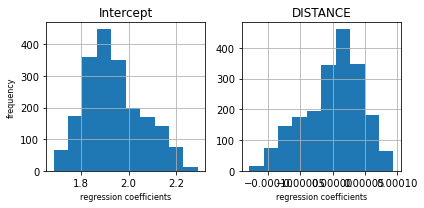

In [214]:
%matplotlib inline  
mrqap.plot('betas', fn=None)